In [4]:
import tensorflow as tf 
import numpy as np
from Bio import SeqIO
import json
from sklearn.model_selection import train_test_split
import feature as fe 
import copy 
from tensorflow.keras import *
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd 
matplotlib.rcParams['font.family']='Simhei'#修改了全局变量

%matplotlib inline 
%config InlineBackend.figure_format = 'jpg' #以矢量图的形式显示图片，这样比较清晰
plt.style.use({'figure.figsize':(20,16)})

In [5]:



def drawlossinTwoSet(data,modelname='未知'):
    y1 = data.history['loss']
    y2 = data.history['val_loss']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'loss'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'loss={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_loss= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_loss= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'loss={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练loss结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)

def drawACCinTwoSet(data,modelname='未知'):
    y1 = data.history['acc']
    y2 = data.history['val_acc']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'ACC'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'acc={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_acc= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_acc= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'acc={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练acc结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)
    
def applynumpyArray1D(arr,func):
    """
    
    """
    array = copy.deepcopy(arr)  
    for i in range(array.shape[0]):
        array[i] = func(array[i])
    return array

def normize(array):
    """
    input: np.array shape = (n,) 一维向量 
    output: 对 输入的数据进行归一化，即 (a_i - a.mean())/a.std  若全为0，则返回原array。
    
    """
    temp = copy.deepcopy(array)
    if (array == 0).all():#应当添加()
        normizedarray = temp
    else:
        normizedarray = (temp-temp.mean())/temp.std()
    return normizedarray
def twoDArraynormize(twoDArray):
    """
    input: np.array, shape = (n,m)  n为样本个数，m为特征个数，  对每一个样本的同一个特征进行归一化处理即 (m_i - m's mean)/m'std
    output: np.array, shape = (n,m) n为样本个数，m为特征个数。 归一化后的结果 

    """
    temp = copy.deepcopy(twoDArray)
    for i in range(temp.shape[1]):
        array = temp[:,i]
        temp[:,i] = normize(array)
    return temp    
    

#词向量化
def amino_acids2numvector(sequenceArray,toknizer):
    """
    input:
        sequence:(n,) np.array类型，多肽序列
        toknizer: 氨基酸toknizer。    
    output:（n,200) 数字化后的多肽序列
    """
    sequenceArray = applynumpyArray1D(sequenceArray,lambda x: ' '.join(x))
    sequenceArray = toknizer.texts_to_sequences(sequenceArray)
    #选取最常长度为20
    sequenceArray = tf.keras.preprocessing.sequence.pad_sequences(sequenceArray,truncating='post',padding='post',maxlen=20)
    return sequenceArray


#AAC Matrix
def aminoacids2AACMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAComposition)
    AACMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AACMatrix = np.array(AACMatrix.tolist())
    return AACMatrix

#DPC Matrix
#DPC Matrix
def aminoacids2DPCMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateDipeptideComposition)
    DPCMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    DPCMatrix = np.array(DPCMatrix.tolist())
    return DPCMatrix

#CTD Matrix
def aminoacids2CTDMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateCTD)
    CTDMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    CTDMatrix = np.array(CTDMatrix.tolist())
    return CTDMatrix
#AAI Matrix
def aminoacids2AAIMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAIndex)
    AAIMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AAIMatrix = np.array(AAIMatrix.tolist())
    return AAIMatrix


def generateFeaturesData(sequenceData,normize=False):
    """
    input:
        sequence:(n,) np.array类型，包含n条多肽序列的数组
    output:[AAC,DPC,CTD,AAI,SeqVec]的一个列表
    """
    data = copy.deepcopy(sequenceData)
    AAC = aminoacids2AACMatrix(data)
    if normize:
        AAC = twoDArraynormize(AAC)
    
    DPC = aminoacids2DPCMatrix(data)
    if normize:
        DPC = twoDArraynormize(DPC)
    
    CTD = aminoacids2CTDMatrix(data)
    if normize:
        CTD = twoDArraynormize(CTD)
    
    AAI = aminoacids2AAIMatrix(data)
    #if normize:
    AAI = twoDArraynormize(AAI)
    
    SeqVec = amino_acids2numvector(data,toknizer)
    return [AAC,DPC,CTD,AAI,SeqVec]

In [6]:
def countFeatures(data):
    import feature 
    """
    input: 输入BCEs或者非BCEs的数据集 pd.DataFrame类型
    output:输出包含AAC、DPC、CTD和AAI的 pd.DataFrame类型
    
    """
    #计算AAC
    data['AAC']= data['Description'].apply(fe.CalculateAAComposition)
    #计算DPC
    data['DPC']= data['Description'].apply(fe.CalculateDipeptideComposition)
    #计算CTD
    data['CTD']= data['Description'].apply(fe.CalculateCTD)
    #计算AAI
    data['AAI']= data['Description'].apply(fe.CalculateAAIndex)
    return data

In [7]:
#读取 词分类器
with open('tfsModel/RNNamino_acids_toknizer.json','r') as f:
    toknizer =tf.keras.preprocessing.text.tokenizer_from_json(json.load(f))

In [8]:
#IBCE-EL的数据集
B_positive = np.array([str(seq.seq) for seq in list(SeqIO.parse('B-positive.txt','fasta'))]).astype('object')
B_negative = np.array([str(seq.seq) for seq in list(SeqIO.parse('B-negative.txt','fasta'))]).astype('object')



In [9]:
#pd.DataFrame(B_positive).to_csv('IBCE_EL_B_positive.csv')
#pd.DataFrame(B_negative).to_csv('IBCE_EL_B_negative.csv')

In [10]:
B_positiveFeatures = generateFeaturesData(B_positive)
B_negativeFeatures = generateFeaturesData(B_negative)

In [11]:
IBCE_ELTargets = np.concatenate([np.ones((B_positiveFeatures[0].shape[0],)),np.zeros((B_negativeFeatures[0].shape[0],))])


In [12]:
IBCE_ELTargets

array([1., 1., 1., ..., 0., 0., 0.])

In [13]:
#测试模型是否可以在IBCE-EL数据集上推广

#测试模型性能
AACModel.evaluate(x=np.concatenate([B_positiveFeatures[0],B_negativeFeatures[0]]),
                 y = IBCE_ELTargets,batch_size=64)

DPCModel.evaluate(x=np.concatenate([B_positiveFeatures[1],B_negativeFeatures[1]]),
                 y = IBCE_ELTargets,batch_size=16)

CTDModel.evaluate(x=np.concatenate([B_positiveFeatures[2],B_negativeFeatures[2]]),
                 y = IBCE_ELTargets,batch_size=16)

AAIModel.evaluate(x=np.concatenate([B_positiveFeatures[3],B_negativeFeatures[3]]),
                 y = IBCE_ELTargets,batch_size=16)



NameError: name 'AACModel' is not defined

In [48]:
#读入特为IBCE训练的模型
#读取模型
IBCE_ELAACModel = tf.keras.models.load_model('tfsModel/IBCE_ELAACModel.h5')
IBCE_ELDPCModel = tf.keras.models.load_model('tfsModel/IBCE_ELDPCModel.h5')
IBCE_ELCTDModel = tf.keras.models.load_model('tfsModel/IBCE_ELCTDModel.h5')
IBCE_ELAAIModel = tf.keras.models.load_model('tfsModel/IBCE_ELAAIModel.h5')
IBCE_ELRNNModel = tf.keras.models.load_model('tfsModel/IBCE_ELRNNModel.h5')

In [50]:

#测试模型性能
IBCE_ELAACModel.evaluate(x=np.concatenate([B_positiveFeatures[0],B_negativeFeatures[0]]),
                 y = IBCE_ELTargets,batch_size=64)

IBCE_ELDPCModel.evaluate(x=np.concatenate([B_positiveFeatures[1],B_negativeFeatures[1]]),
                 y = IBCE_ELTargets,batch_size=16)

IBCE_ELCTDModel.evaluate(x=np.concatenate([B_positiveFeatures[2],B_negativeFeatures[2]]),
                 y = IBCE_ELTargets,batch_size=16)

IBCE_ELAAIModel.evaluate(x=np.concatenate([B_positiveFeatures[3],B_negativeFeatures[3]]),
                 y = IBCE_ELTargets,batch_size=16)
IBCE_ELRNNModel.evaluate(x=np.concatenate([B_positiveFeatures[4],B_negativeFeatures[4]]),
                 y = IBCE_ELTargets,batch_size=16)


621/621 [==============================] - 2s 2ms/step - loss: 0.6120 - acc: 0.6915 - auc_15: 0.7419


[0.6119837760925293, 0.691486120223999, 0.7418538331985474]

In [73]:
#生成模型预测Prob作为集合学习的模型的数据输入

#测试模型性能
AACProb = IBCE_ELAACModel.predict(x=np.concatenate([B_positiveFeatures[0],B_negativeFeatures[0]]))

DPCProb = IBCE_ELDPCModel.predict(x=np.concatenate([B_positiveFeatures[1],B_negativeFeatures[1]]))

CTDProb = IBCE_ELCTDModel.predict(x=np.concatenate([B_positiveFeatures[2],B_negativeFeatures[2]]))

AAIProb = IBCE_ELAAIModel.predict(x=np.concatenate([B_positiveFeatures[3],B_negativeFeatures[3]]))
RNNProb = IBCE_ELRNNModel.predict(x=np.concatenate([B_positiveFeatures[4],B_negativeFeatures[4]]))



EnsembleModelTargets = IBCE_ELTargets

In [32]:
AACProb =IBCE_ELAACModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]),)
DPCProb =IBCE_ELDPCModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]),)
CTDProb =IBCE_ELCTDModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]),)
AAIProb =IBCE_ELAAIModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]),)
RNNProb =IBCE_ELRNNModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]))
EnsembleModelTargets = milkAllergyTargets

In [17]:
#牛奶过敏数据集
milkAllergyBCEs = pd.read_csv('milk allergy linear BCEs bovine dataset.csv')['Description'].values
milkAllergynonBCEs = pd.read_csv('milk allergy linear non-BCEs experiece confirmed.csv')['Description'].values
milkAllergyBCEsFeatures = generateFeaturesData(milkAllergyBCEs)
milkAllergynonBCEsFeatures = generateFeaturesData(milkAllergynonBCEs)
milkAllergyTargets = np.concatenate([np.ones((milkAllergyBCEsFeatures[0].shape[0],)),np.zeros((milkAllergynonBCEsFeatures[0].shape[0],))])



In [18]:
#x_train, x_test, y_train, y_test = train_test_split( x_data, y_data, test_size=0.1)
#MilkTrainDataset  = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(1000).batch(100)
#MilktestDataset  = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(1000).batch(100)

In [36]:
#读取模型
AACModel = tf.keras.models.load_model('tfsModel/AACModel.h5')
DPCModel = tf.keras.models.load_model('tfsModel/DPCModel.h5')
CTDModel = tf.keras.models.load_model('tfsModel/CTDModel.h5')
AAIModel = tf.keras.models.load_model('tfsModel/AAIModelnormized.h5')
RNNModel = tf.keras.models.load_model('tfsModel/RNNModel.h5')

In [20]:
#测试模型性能
AACModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]),
                 y = milkAllergyTargets,batch_size=16)

DPCModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]),
                 y = milkAllergyTargets,batch_size=16)

CTDModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]),
                 y = milkAllergyTargets,batch_size=16)

AAIModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]),
                 y = milkAllergyTargets,batch_size=16)
RNNModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]),
                 y = milkAllergyTargets,batch_size=16)

29/29 [==============================] - 1s 2ms/step - loss: 0.8369 - acc: 0.7888 - auc: 0.8161


[0.8369380235671997, 0.7887930870056152, 0.8161486387252808]

In [82]:
#生成模型预测Prob作为集合学习的模型的数据输入
AACProb =AACModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]),)
DPCProb =DPCModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]),)
CTDProb =CTDModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]),)
AAIProb =AAIModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]),)
RNNProb =RNNModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]))

EnsembleModelTargets = milkAllergyTargets

In [87]:
#整合输入数据
EnsembleModelInput = np.concatenate([AACProb,DPCProb,CTDProb,AAIProb],axis=1)
print(EnsembleModelInput.shape)

EM_Xtrain,EM_Xtest,EM_Ytrain,EM_Ytest = train_test_split(EnsembleModelInput,EnsembleModelTargets,test_size=0.3)

print(EM_Xtrain.shape,EM_Ytrain.shape,'\n',EM_Xtest.shape,EM_Ytest.shape)

EMTrainData = tf.data.Dataset.from_tensor_slices((EM_Xtrain,EM_Ytrain)).shuffle(1000).batch(32)
EMTestData = tf.data.Dataset.from_tensor_slices((EM_Xtest,EM_Ytest)).shuffle(1000).batch(32)




(464, 4)
(324, 4) (324,) 
 (140, 4) (140,)


In [88]:
EnsembleModel = models.Sequential()
EnsembleModel.add(layers.Dense(1,input_shape=(4,),activation='sigmoid'))
EnsembleModel.compile(optimizer=optimizers.Nadam(lr=0.05),
                      loss = losses.binary_crossentropy,
                      metrics=['acc','mae','AUC'])

In [89]:
EMhistory = EnsembleModel.fit(EMTrainData,validation_data=EMTestData,epochs=80)

Epoch 1/80
11/11 [==============================] - 1s 21ms/step - loss: 0.8361 - acc: 0.3467 - mae: 0.5542 - auc: 0.2061 - val_loss: 0.7073 - val_acc: 0.5714 - val_mae: 0.4980 - val_auc: 0.4855
Epoch 2/80
11/11 [==============================] - 0s 4ms/step - loss: 0.7076 - acc: 0.5466 - mae: 0.4948 - auc: 0.5791 - val_loss: 0.6256 - val_acc: 0.6857 - val_mae: 0.4550 - val_auc: 0.7305
Epoch 3/80
11/11 [==============================] - 0s 4ms/step - loss: 0.6262 - acc: 0.6831 - mae: 0.4544 - auc: 0.7668 - val_loss: 0.5480 - val_acc: 0.7571 - val_mae: 0.4075 - val_auc: 0.8598
Epoch 4/80
11/11 [==============================] - 0s 4ms/step - loss: 0.5509 - acc: 0.7469 - mae: 0.4096 - auc: 0.8920 - val_loss: 0.5067 - val_acc: 0.8143 - val_mae: 0.3854 - val_auc: 0.9035
Epoch 5/80
11/11 [==============================] - 0s 3ms/step - loss: 0.5039 - acc: 0.8172 - mae: 0.3837 - auc: 0.9127 - val_loss: 0.4504 - val_acc: 0.8571 - val_mae: 0.3440 - val_auc: 0.9266
Epoch 6/80
11/11 [===========

/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22902 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36807 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25935 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0.0, flags=fl

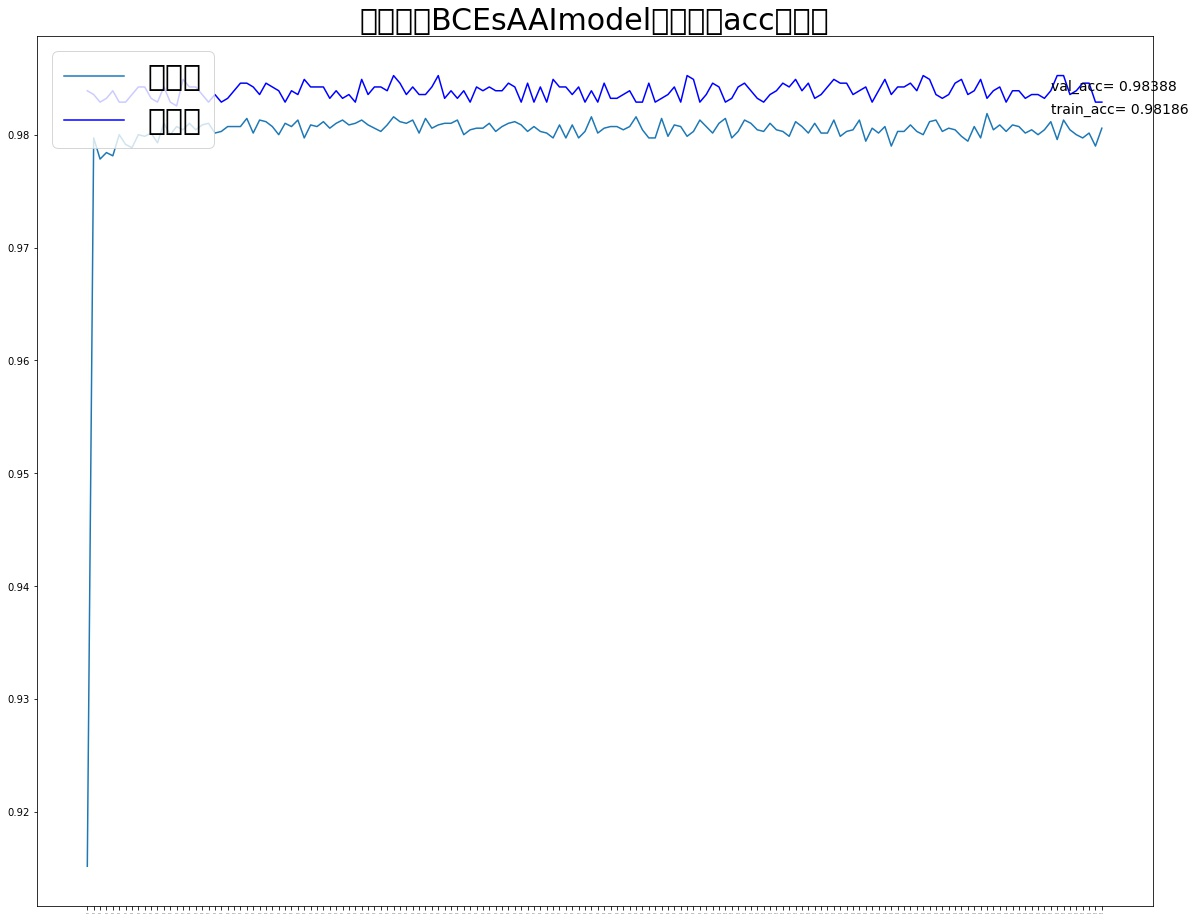

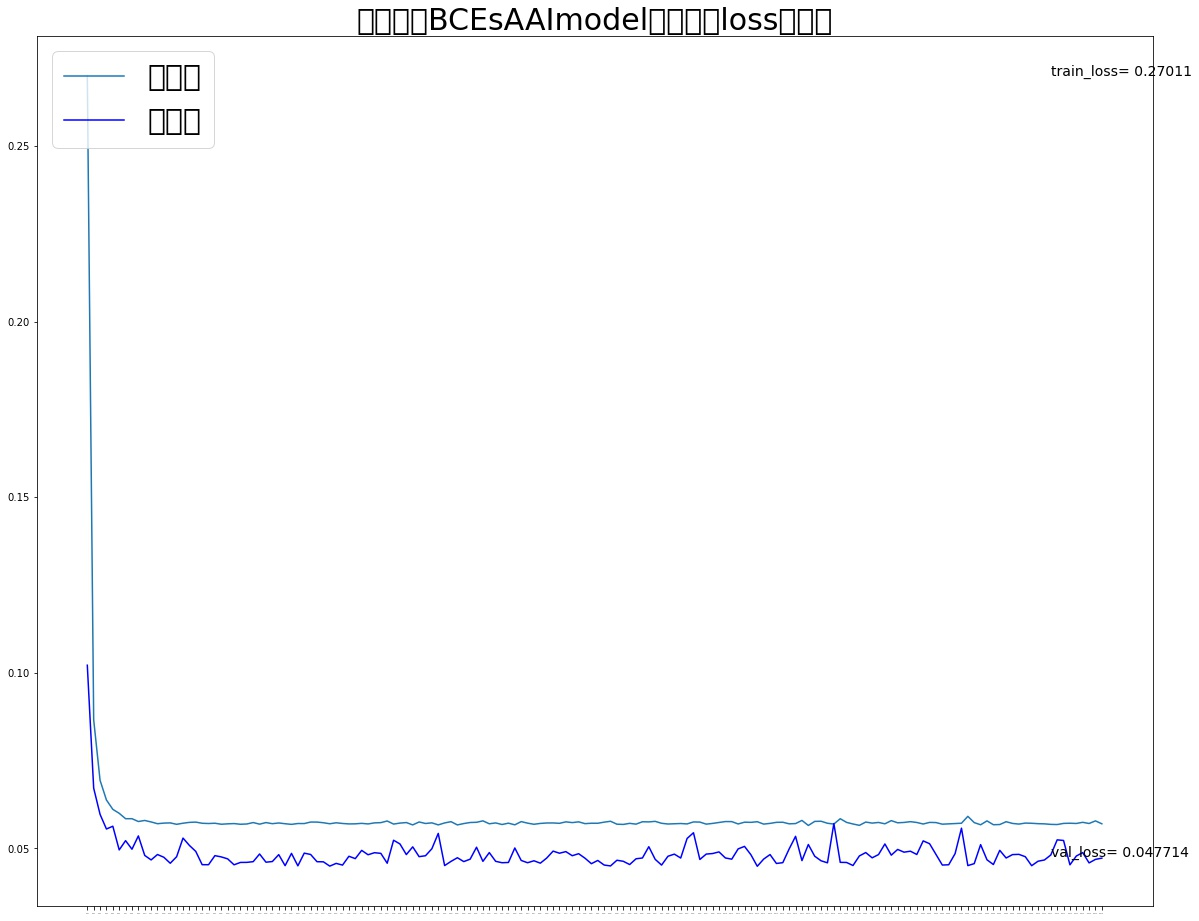

In [60]:
drawACCinTwoSet(EMhistory,'AAImodel')
plt.figure()
drawlossinTwoSet(EMhistory,'AAImodel')

In [90]:
EnsembleModel.save('tfsModel/EM_AAC_DPC_CTD_AAInomized.h5')

In [91]:
EnsembleModel.weights

[<tf.Variable 'dense_9/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[3.3373156],
        [3.7600248],
        [3.0416725],
        [2.0923488]], dtype=float32)>,
 <tf.Variable 'dense_9/bias:0' shape=(1,) dtype=float32, numpy=array([-5.9210625], dtype=float32)>]

In [92]:
AACProb.shape 

(464, 1)